In [2]:
# import libraries
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import gc
import pickle
from sklearn import tree
from sklearn.metrics import r2_score

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
need = pd.read_csv('test.csv', sep=';')
need.head()

,SUBSCRIBER_ID
0,114104
1,19422
2,141225
3,163493
4,220775


In [6]:
week = pd.read_csv('weekly_consumption.csv', sep=';')
week.head()

KeyboardInterrupt: 

In [7]:
cust = pd.read_csv('subscribers_info.csv', sep=';')
cust.head()

,SUBSCRIBER_ID,PRICE_PLAN_CHANGE_DATE,STATUS,LT,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP
0,0,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
1,1,2017-10-02 00:00:00,Active,4786.0,2017-09-20 08:14:19,dealer,PRICE_PLAN_GROUP_0
2,2,2016-11-09 00:00:00,Non-active,5052.0,NaN,dealer,PRICE_PLAN_GROUP_1
3,3,2017-11-29 00:00:00,Active,4242.0,NaN,dealer,PRICE_PLAN_GROUP_0
4,4,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0


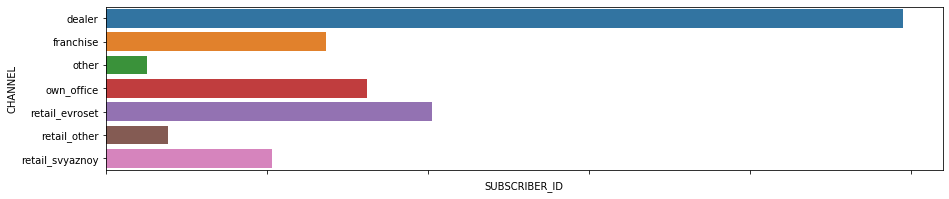

In [9]:
tx_revenue = cust.groupby(['CHANNEL'])['SUBSCRIBER_ID'].nunique().reset_index()
plt.figure(figsize=(15, 3))
gr = sns.barplot(y='CHANNEL',
                x='SUBSCRIBER_ID',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

In [8]:
cust['CHANNEL'] = cust['CHANNEL'].apply(lambda x: 'other' if x in ('b2c_agent', 'digital', 'electronics_store', 'sampling', '???') else x)

In [10]:
len(set(cust['SUBSCRIBER_ID']))

232789

In [11]:
len(set(cust[cust['STATUS'] == 'Non-active'].SUBSCRIBER_ID))

16057

Рассмотрим структуру данных

In [47]:
df = week.set_index('SUBSCRIBER_ID').join(cust.set_index('SUBSCRIBER_ID'), on='SUBSCRIBER_ID', how='inner', lsuffix='_left', rsuffix='_right').reset_index()
df = df.sort_values(['SUBSCRIBER_ID', 'TIME_KEY'], ascending=[True, True])

In [14]:
df.isnull().sum()

SUBSCRIBER_ID                        0
TIME_KEY                             0
LAST_BALANCE                         0
LT_left                              0
SUM_RECHARGE                         0
COUNT_RECHARGE                       0
MAX_RECHARGE                         0
MIN_RECHARGE                         0
ARPU                                 0
AVG_BALANCE                          0
MAX_BALANCE                          0
MIN_BALANCE                          0
AVG_BALANCE_BEFORE_RECHARGE          0
HOURS_FROM_LAST_RECHARGE             0
DATA_TRAFFIC                         0
COUNT_SMS_OUT                        0
TOTAL_OUT                            0
TOTAL_IN                             0
UNIQUE_NUMBERS                       0
DAYS_IN_BLOCK                        0
DAYS_WITH_TRANSACTIONS               0
OUT_ONNET                            0
OUT_LOCAL_ONNET                      0
OUT_LOCAL_OFFNET                     0
IN_LOCAL_ONNET                       0
IN_LOCAL_OFFNET          

In [48]:
df.to_csv('df_basis.csv', index=False)

### Шаг 0. Вводная часть

In [283]:
tx_revenue = tx_revenue.set_index(pd.DatetimeIndex(tx_revenue['TIME_KEY']))

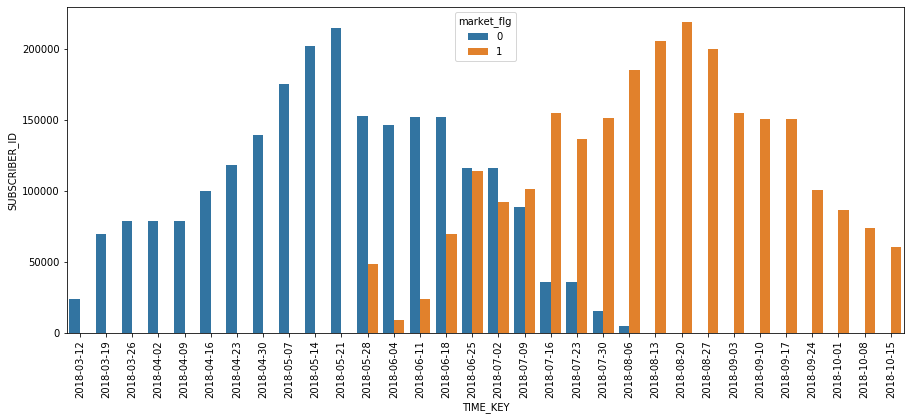

In [157]:
tx_revenue =init.groupby(['TIME_KEY', 'market_flg'])['SUBSCRIBER_ID'].nunique().reset_index()
tx_revenue['TIME_KEY'] = tx_revenue['TIME_KEY'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(15, 6))
gr = sns.barplot(y='SUBSCRIBER_ID',
                x='TIME_KEY',
                hue='market_flg',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

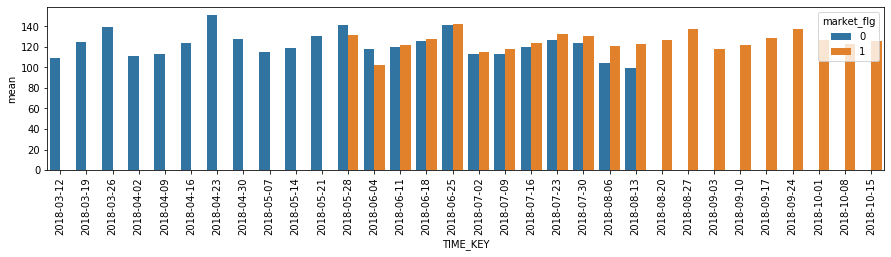

In [170]:
tx_revenue =init.groupby(['TIME_KEY', 'market_flg'])['ARPU_now'].agg(['mean', 'median', 'count']).reset_index()
tx_revenue['TIME_KEY'] = tx_revenue['TIME_KEY'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(15, 3))
gr = sns.barplot(y='mean',
                x='TIME_KEY',
                hue='market_flg',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

In [171]:
tx_revenue[tx_revenue['market_flg'] == 0].set_index(['TIME_KEY']).join(tx_revenue[tx_revenue['market_flg'] == 1].\
                                                        set_index(['TIME_KEY']), \
                                                        on=['TIME_KEY'], how='inner', lsuffix='_after', rsuffix='_before').reset_index()

,TIME_KEY,market_flg_after,mean_after,median_after,count_after,market_flg_before,mean_before,median_before,count_before
0,2018-05-28,0,140.918962,116.69,152512,1,131.622565,109.69,48749
1,2018-06-04,0,117.908722,99.69,146635,1,102.220164,90.69,9016
2,2018-06-11,0,119.646350,103.31,151741,1,121.928371,102.19,23843
3,2018-06-18,0,125.969141,109.69,151740,1,128.116734,109.69,69356
4,2018-06-25,0,141.530250,116.69,116172,1,142.442564,116.69,114081
5,2018-07-02,0,113.010579,96.81,116208,1,115.233763,93.31,92425
6,2018-07-09,0,113.247666,97.81,88540,1,117.688152,96.69,101595
7,2018-07-16,0,119.663394,105.31,36236,1,124.118136,105.00,154793
8,2018-07-23,0,126.725512,109.69,36236,1,132.392612,112.00,136869
9,2018-07-30,0,123.573857,103.81,15767,1,130.823482,109.69,151225


### Шаг 1. Обработаем данные

У нас есть данные несколько маркетинговых коммуникаций (дата сбора профиля - дата маркетинговой коммуникации)

#### 1. Рассмотрим данные по марк.ком ( марк.ком = тест). Определяем даты тестов

In [15]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP
4093327,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
4093325,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
4093317,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
4093328,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
4093326,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0


In [10]:
df['market_flg'] = df['LT_left'] - df['LT_right']
df['market_flg'] = df['market_flg'].apply(lambda x: 1 if x >=0 else 0)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,market_flg
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0


#### 2. Добавим фичи на основе времени

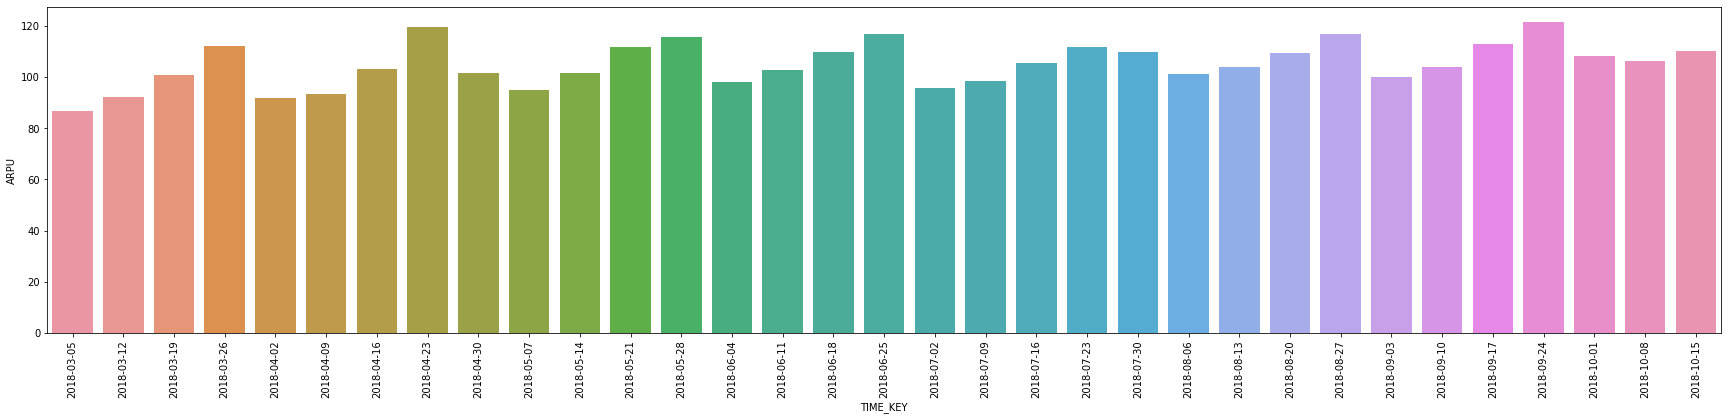

In [301]:
tx_revenue =df.groupby(['TIME_KEY'])['ARPU'].median().reset_index()
plt.figure(figsize=(30, 6))
gr = sns.barplot(y='ARPU',
                x='TIME_KEY',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

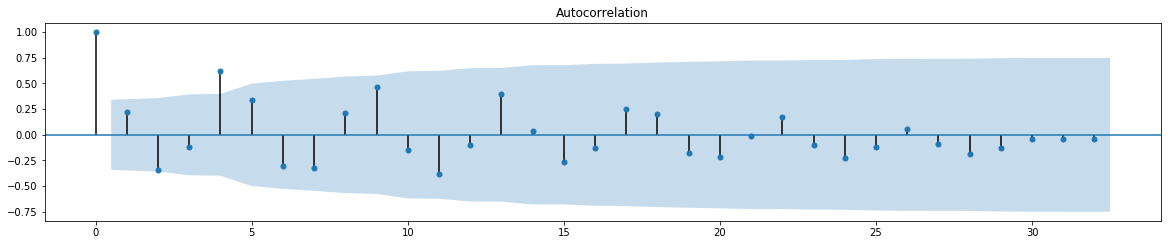

In [291]:
plt.figure(figsize(20,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(tx_revenue.ARPU.values.squeeze(), lags=32, ax=ax)
pylab.show()

Вывод: видим корр. с номером недели в месяце. Поэтому добавим день недели

In [11]:
df['TIME_KEY'] = df['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0)) - 1

In [13]:
df['week_of_month'] = df['TIME_KEY'].apply(lambda x: week_of_month(x))

In [14]:
df['num_of_month'] = df['TIME_KEY'].apply(lambda x: x.month)

In [15]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,1,5
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,2,5
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,3,5
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,4,5
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,1,6


#### 3. Добавляем среднее до момента наблюдения

In [51]:
means = df[['SUBSCRIBER_ID', 'TIME_KEY', 'ARPU']]
means.ARPU = means.ARPU.apply(lambda x: int(round(x)))
means.head()

,SUBSCRIBER_ID,TIME_KEY,ARPU
4093327,0,2018-05-07,82
4093325,0,2018-05-14,82
4093317,0,2018-05-21,82
4093328,0,2018-05-28,132
4093326,0,2018-06-04,82


In [99]:
means_col = means.groupby(['SUBSCRIBER_ID']).rolling('10D', on='TIME_KEY').mean().reset_index(drop=True)

In [ ]:
means_col.to_csv('means_col.csv', index=False)
means_col.head()

In [16]:
means_col = pd.read_csv('means_col.csv', sep=',')
means_col['TIME_KEY'] = means_col['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
means_col.head()

,SUBSCRIBER_ID,TIME_KEY,ARPU
0,0.0,2018-05-07,82.0
1,0.0,2018-05-14,82.0
2,0.0,2018-05-21,82.0
3,0.0,2018-05-28,107.0
4,0.0,2018-06-04,107.0


In [17]:
df = df.set_index(['SUBSCRIBER_ID', 'TIME_KEY'])\
    .join(means_col.set_index(['SUBSCRIBER_ID', 'TIME_KEY']), on=['SUBSCRIBER_ID', 'TIME_KEY'], how='inner', lsuffix='_current', rsuffix='_mean').reset_index()
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,1,5,82.0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0


In [18]:
df.to_csv('df_init.csv', index=False)

In [5]:
df = pd.read_csv('df_init.csv', sep=',')

#### 4. Нормализируем данные

In [18]:
df.columns

Index(['SUBSCRIBER_ID', 'TIME_KEY', 'LAST_BALANCE', 'LT_left', 'SUM_RECHARGE', 'COUNT_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'ARPU_current', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', 'AVG_BALANCE_BEFORE_RECHARGE', 'HOURS_FROM_LAST_RECHARGE', 'DATA_TRAFFIC', 'COUNT_SMS_OUT', 'TOTAL_OUT', 'TOTAL_IN', 'UNIQUE_NUMBERS', 'DAYS_IN_BLOCK', 'DAYS_WITH_TRANSACTIONS', 'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'PRICE_PLAN_CHANGE_DATE', 'STATUS', 'LT_right', 'LAST_DEVICE_CHANGE_DATE', 'CHANNEL', 'PRICE_PLAN_GROUP', 'market_flg', 'week_of_month', 'num_of_month', 'ARPU_mean'], dtype='object')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
for x in ['LAST_BALANCE', 'SUM_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', \
         'AVG_BALANCE_BEFORE_RECHARGE', 'DATA_TRAFFIC', 'TOTAL_OUT', 'TOTAL_IN', 'COUNT_SMS_OUT',\
         'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'LT_right', 'LT_left']:
    tr = scaler.fit_transform(df[x].values.reshape(-1, 1))
    df[x] = tr
    
scaler = MinMaxScaler()
for x in ['HOURS_FROM_LAST_RECHARGE', 'UNIQUE_NUMBERS', 'DAYS_WITH_TRANSACTIONS', 'DAYS_IN_BLOCK']:
    tr = scaler.fit_transform(df[x].values.reshape(-1, 1))
    df[x] = tr 
    
df.drop(columns=['PRICE_PLAN_CHANGE_DATE', 'LAST_DEVICE_CHANGE_DATE'], inplace=True)    
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,0.439822,1.364537,-0.473000,0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,5,82.0
1,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0
2,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0
3,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0
4,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0


#### 5. Прикрепим данные за последний период

In [7]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,0.439822,1.364537,-0.473000,0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,5,82.0
1,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0
2,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0
3,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0
4,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0


In [8]:
df.shift(1).head().reset_index()

,index,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0
2,2,0.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0
3,3,0.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0
4,4,0.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0


1 week

In [9]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df.shift(1).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='inner', rsuffix='_1').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0


In [10]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0


2 week

In [11]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(2).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_2').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0,NaN
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0,NaN
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0,81.69
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0,81.69
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0,131.69


In [12]:
len(df)

5037953

3 week

In [13]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(3).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_3').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0,NaN,NaN
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0,NaN,NaN
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0,81.69,NaN
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0,81.69,81.69
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0,131.69,81.69


In [14]:
len(df)

5037953

4 week

In [15]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(4).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_4').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0,NaN,NaN,NaN
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0,NaN,NaN,NaN
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0,81.69,NaN,NaN
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0,81.69,81.69,NaN
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0,131.69,81.69,81.69


In [16]:
len(df)

5037953

5 week

In [17]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(5).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_5').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0,NaN,NaN,NaN,NaN
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0,NaN,NaN,NaN,NaN
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0,81.69,NaN,NaN,NaN
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0,81.69,81.69,NaN,NaN
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0,131.69,81.69,81.69,NaN


In [18]:
len(df)

5037953

#### 6. См. на пропуски данных

In [21]:
df.isnull().sum()

SUBSCRIBER_ID                          0
TIME_KEY                               0
LAST_BALANCE                           0
LT_left                                0
SUM_RECHARGE                           0
COUNT_RECHARGE                         0
MAX_RECHARGE                           0
MIN_RECHARGE                           0
ARPU_current                           0
AVG_BALANCE                            0
MAX_BALANCE                            0
MIN_BALANCE                            0
AVG_BALANCE_BEFORE_RECHARGE            0
HOURS_FROM_LAST_RECHARGE               0
DATA_TRAFFIC                           0
COUNT_SMS_OUT                          0
TOTAL_OUT                              0
TOTAL_IN                               0
UNIQUE_NUMBERS                         0
DAYS_IN_BLOCK                          0
DAYS_WITH_TRANSACTIONS                 0
OUT_ONNET                              0
OUT_LOCAL_ONNET                        0
OUT_LOCAL_OFFNET                       0
IN_LOCAL_ONNET  

In [22]:
df.fillna(0, inplace=True)

In [23]:
df.columns

Index(['SUBSCRIBER_ID', 'TIME_KEY', 'LAST_BALANCE', 'LT_left', 'SUM_RECHARGE', 'COUNT_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'ARPU_current', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', 'AVG_BALANCE_BEFORE_RECHARGE', 'HOURS_FROM_LAST_RECHARGE', 'DATA_TRAFFIC', 'COUNT_SMS_OUT', 'TOTAL_OUT', 'TOTAL_IN', 'UNIQUE_NUMBERS', 'DAYS_IN_BLOCK', 'DAYS_WITH_TRANSACTIONS', 'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'STATUS', 'LT_right', 'CHANNEL', 'PRICE_PLAN_GROUP', 'market_flg', 'week_of_month', 'num_of_month', 'ARPU_mean', 'TIME_KEY_1', 'LAST_BALANCE_1', 'LT_left_1', 'SUM_RECHARGE_1', 'COUNT_RECHARGE_1', 'MAX_RECHARGE_1', 'MIN_RECHARGE_1', 'ARPU_current_1', 'AVG_BALANCE_1', 'MAX_BALANCE_1', 'MIN_BALANCE_1', 'AVG_BALANCE_BEFORE_RECHARGE_1', 'HOURS_FROM_LAST_RECHARGE_1', 'DATA_TRAFFIC_1', 'COUNT_SMS_OUT_1', 'TOTAL_OUT_1', 'TOTAL_IN_1', 'UNIQUE_NUMBERS_1', 'DAYS_IN_BLOCK_1', 'DAYS_WITH_TRANSACTIONS_1', 'OUT_ONNET_1', 'OUT_LOCAL_ONNET_1',
       'OU

In [24]:
df.to_csv('df_before_predpro.csv', index=False)

In [8]:
df = pd.read_csv('df_before_predpro.csv', sep=',')

In [9]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,ARPU_current_6
0,0,2018-05-14,0.745472,1.368941,0.170365,2,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
1,0,2018-05-21,0.494442,1.373346,-0.473000,0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,2.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
2,0,2018-05-28,0.089728,1.377750,-0.473000,0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,3.0,5.0,82.0,81.69,0.00,0.00,0.0,0.0
3,0,2018-06-04,0.392610,1.382154,0.167168,1,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,4.0,5.0,107.0,81.69,81.69,0.00,0.0,0.0
4,0,2018-06-11,0.141581,1.386559,-0.473000,0,-0.589076,-0.607489,81.69,0.252317,0.088834,0.437184,-0.020059,1.000000,-0.182256,-0.252814,0.429120,0.494239,0.033275,0.0,1.0,0.525346,0.762147,0.100615,0.214410,1.057653,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0.0,1.0,6.0,107.0,131.69,81.69,81.69,0.0,0.0


In [10]:
df['TIME_KEY'] = df['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
df = df[[
    
    'SUBSCRIBER_ID', 'TIME_KEY',
    #
    'ARPU_current',
    #
    'STATUS', 'LT_right', 'CHANNEL', 'PRICE_PLAN_GROUP', 'market_flg', 
    
    'week_of_month', 'num_of_month', 'ARPU_mean', 
    
    'TIME_KEY_1', 'LAST_BALANCE_1', 'LT_left_1', 'SUM_RECHARGE_1', 'COUNT_RECHARGE_1', 'MAX_RECHARGE_1', 
    'MIN_RECHARGE_1', 'ARPU_current_1', 'AVG_BALANCE_1', 'MAX_BALANCE_1', 'MIN_BALANCE_1', 'AVG_BALANCE_BEFORE_RECHARGE_1',
    'HOURS_FROM_LAST_RECHARGE_1', 'DATA_TRAFFIC_1', 'COUNT_SMS_OUT_1', 'TOTAL_OUT_1', 'TOTAL_IN_1', 'UNIQUE_NUMBERS_1', 
    'DAYS_IN_BLOCK_1', 'DAYS_WITH_TRANSACTIONS_1', 'OUT_ONNET_1', 'OUT_LOCAL_ONNET_1', 'OUT_LOCAL_OFFNET_1', 
    'IN_LOCAL_ONNET_1', 'IN_LOCAL_OFFNET_1', 
    
    'week_of_month_1', 'num_of_month_1', 'ARPU_mean_1', 
    'ARPU_current_2', 'ARPU_current_3', 'ARPU_current_4', 'ARPU_current_5']]

In [12]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,ARPU_current,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,ARPU_current_6
0,0,2018-05-14,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,2018-05-07,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,1.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
1,0,2018-05-21,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,2018-05-14,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,2.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
2,0,2018-05-28,131.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,2018-05-21,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,3.0,5.0,82.0,81.69,0.00,0.00,0.0,0.0
3,0,2018-06-04,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,2018-05-28,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,4.0,5.0,107.0,81.69,81.69,0.00,0.0,0.0
4,0,2018-06-11,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,2018-06-04,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,1.0,6.0,107.0,131.69,81.69,81.69,0.0,0.0


In [13]:
df.drop(columns=['TIME_KEY','TIME_KEY_1'], inplace=True)
df.head()

,SUBSCRIBER_ID,ARPU_current,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,ARPU_current_6
0,0,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,1.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
1,0,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,2.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0
2,0,131.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,3.0,5.0,82.0,81.69,0.00,0.00,0.0,0.0
3,0,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,4.0,5.0,107.0,81.69,81.69,0.00,0.0,0.0
4,0,81.69,Active,1.411502,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,1.0,6.0,107.0,131.69,81.69,81.69,0.0,0.0


In [14]:
df = pd.get_dummies(df)
df.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,ARPU_current_6,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
0,0,81.69,1.411502,0,2,5,82.0,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,1.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,0,81.69,1.411502,0,3,5,82.0,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,2.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
2,0,131.69,1.411502,0,4,5,107.0,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,3.0,5.0,82.0,81.69,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
3,0,81.69,1.411502,0,1,6,107.0,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,4.0,5.0,107.0,81.69,81.69,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,0,81.69,1.411502,0,2,6,82.0,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,1.0,6.0,107.0,131.69,81.69,81.69,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [15]:
len(df)

5037953

#### 7. Делим на тест/контроль

In [16]:
import random
from random import randrange

In [17]:
cust['test_flg'] = cust['SUBSCRIBER_ID'].apply(lambda x: 1 if randrange(5) == 0 else 0)
len(cust[cust['test_flg'] == 1]) / (len(cust[cust['test_flg'] == 0]) + len(cust[cust['test_flg'] == 1]))

0.20103183569670388

In [18]:
df = df.reset_index().set_index(['SUBSCRIBER_ID'])\
    .join(cust[['SUBSCRIBER_ID', 'test_flg']].reset_index().set_index(['SUBSCRIBER_ID']), on=['SUBSCRIBER_ID'], \
    how='inner', lsuffix='_now', rsuffix='_delete').reset_index()
df.drop(columns=['index_delete', 'index_now'], inplace=True)
df.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,ARPU_current_6,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,test_flg
0,0,81.69,1.411502,0,2,5,82.0,0.439822,1.364537,-0.473000,0.0,-0.589076,-0.607489,81.69,0.560729,0.356974,0.750752,-0.020059,1.000000,-0.067288,-0.320671,0.008406,-0.151355,0.021891,0.0,1.0,-0.368538,-0.260875,0.967439,-0.403451,0.345404,1.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,0,81.69,1.411502,0,3,5,82.0,0.745472,1.368941,0.170365,2.0,-0.103707,-0.028807,81.69,0.507361,0.422192,0.599963,1.610844,0.059524,-0.276994,-0.320671,-0.023743,0.156441,0.021891,0.0,1.0,-0.142507,-0.068048,0.413893,-0.563337,1.397311,2.0,5.0,82.0,0.00,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,131.69,1.411502,0,4,5,107.0,0.494442,1.373346,-0.473000,0.0,-0.589076,-0.607489,81.69,0.617211,0.406081,0.808178,-0.020059,1.000000,-0.087602,-0.184957,0.133811,0.165462,0.030648,0.0,1.0,-0.244916,-0.215947,1.011970,-0.278598,0.960903,3.0,5.0,82.0,81.69,0.00,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0,81.69,1.411502,0,1,6,107.0,0.089728,1.377750,-0.473000,0.0,-0.589076,-0.607489,131.69,0.244116,0.180387,0.382666,-0.020059,1.000000,0.132736,-0.320671,-0.036944,-0.035538,0.026270,0.0,1.0,-0.181276,-0.046559,0.461015,-0.256632,0.793134,4.0,5.0,107.0,81.69,81.69,0.00,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
4,0,81.69,1.411502,0,2,6,82.0,0.392610,1.382154,0.167168,1.0,0.372061,0.549875,81.69,0.511907,0.298388,0.344985,0.939336,0.928571,-0.281379,-0.320671,0.669923,0.313801,0.030648,0.0,1.0,0.469264,0.697963,0.800701,-0.054200,1.081327,1.0,6.0,107.0,131.69,81.69,81.69,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,1


In [19]:
df.to_csv('df_before.csv', index=False)
del [cust]

In [20]:
df = pd.read_csv('df_before.csv', sep=',')
df.drop(columns=['ARPU_current_6'], inplace=True)

In [21]:
train, test = df[df['test_flg'] == 0], df[df['test_flg'] == 1]

In [22]:
print(len(test) / (len(train) + len(test)))

0.20112930787563918


In [23]:
len(train)

4024673

In [24]:
test = test[(test['SUBSCRIBER_ID'] % 4 == 0)]

In [25]:
train = train[(train['SUBSCRIBER_ID'] % 4 == 0)]

#### 8. Закодируем категор. переменные

In [61]:
train.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,test_flg
206,10,161.0,0.749961,0,3,5,171.0,0.247286,0.700748,1.249984,4.0,1.011041,-0.414809,180.9,-0.177451,0.173258,-0.721721,-0.089786,0.511905,2.570037,2.325757,1.171756,0.482909,0.009632,0.0,1.0,1.684031,1.831492,-0.638826,-0.632575,-0.654014,2.0,5.0,181.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
207,10,161.0,0.749961,0,4,5,161.0,-0.247581,0.705152,-0.473000,0.0,-0.589076,-0.607489,161.0,-0.042046,-0.053320,0.028024,-0.020059,1.000000,1.294112,0.357900,2.041926,0.471369,0.011384,0.0,1.0,2.643018,0.370351,-0.665234,-0.632575,-0.654014,3.0,5.0,171.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
208,10,161.0,0.749961,0,1,6,161.0,-0.742447,0.709557,-0.473000,0.0,-0.589076,-0.607489,161.0,-0.553789,-0.498239,-0.492273,-0.020059,1.000000,0.563360,-0.320671,0.483838,1.699196,0.013135,0.0,1.0,0.869391,0.182546,-0.660574,-0.559722,-0.641663,4.0,5.0,161.0,161.0,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
209,10,161.0,0.749961,0,2,6,161.0,-0.161517,0.713961,0.770390,1.0,1.277728,1.640443,161.0,-0.270900,-0.075455,-0.640929,-0.977068,0.708333,-0.069561,-0.252814,1.384455,1.125148,0.011384,0.0,1.0,1.970287,1.786007,-0.665234,-0.526911,-0.654014,1.0,6.0,161.0,161.0,161.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
210,10,141.0,0.749961,0,3,6,151.0,-0.656383,0.718365,-0.473000,0.0,-0.589076,-0.607489,161.0,-0.464790,-0.420862,-0.401787,-0.020059,1.000000,1.014899,0.425757,0.554524,1.183895,0.012259,0.0,1.0,1.001791,1.305471,-0.656433,-0.632575,-0.654014,2.0,6.0,161.0,161.0,161.0,161.0,0.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0


In [62]:
len(train)

402411

In [26]:
X_train, y_train = train.iloc[:, 2:], train.iloc[:, 1]
X_test, y_test = test.iloc[:, 2:], test.iloc[:, 1]
X_train.drop(columns=['test_flg'], inplace=True)
X_test.drop(columns=['test_flg'], inplace=True)

In [27]:
X_train.head()

,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
89,1.990586,0,2,6,93.0,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,93.31,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
90,1.990586,0,3,6,93.0,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,93.31,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
91,1.990586,0,4,6,103.0,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,93.31,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,93.0,93.31,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
92,1.990586,0,1,7,135.0,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,113.31,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,103.0,93.31,93.31,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
93,1.990586,0,2,7,160.0,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,157.31,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,135.0,113.31,93.31,93.31,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [28]:
len(X_train)

1006015

### Шаг 2. Начнем обучать

#### 1. Бустинг

In [66]:
models_param_grid = [ 
                    { # 2nd param grid, corresponding to XGBRegressor
                            'learning_rate': [0.1],
                            'n_estimators': [700],
                    }]

reg = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

In [67]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1) 

In [68]:
clf = GridSearchCV(estimator=reg, param_grid=models_param_grid, cv=inner_cv)
clf.fit(X_train, y_train)
clf.best_score_

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.9483152157390089

Сохраняем модель

In [36]:
#best_boost = clf.best_estimator_
#pickle.dump(best_boost, open("model_end.dat", "wb"))

In [51]:
best_boost = clf.best_estimator_
pickle.dump(best_boost, open("model.dat", "wb"))

In [51]:
best_boost = pickle.load(open("model_end.dat", "rb"))

In [52]:
clf.best_params_

{'learning_rate': 0.5, 'n_estimators': 300}

In [12]:
plt.figure(figsize(20,8))
xgb.plot_importance(clf.best_estimator_)

AttributeError: 'function' object has no attribute 'best_estimator_'

<Figure size 1440x576 with 0 Axes>

In [53]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
imp = best_boost.get_booster().get_score(importance_type= f)

In [54]:
imp = sorted(imp.items(), key=lambda x:x[1], reverse=True)

In [55]:
y = [imp[i][0] for i in range(len(imp))]
x = [imp[i][1] for i in range(len(imp))]

In [57]:
imp = pd.DataFrame()
imp['Features'] = y[:15]
imp['Scores'] = x[:15]

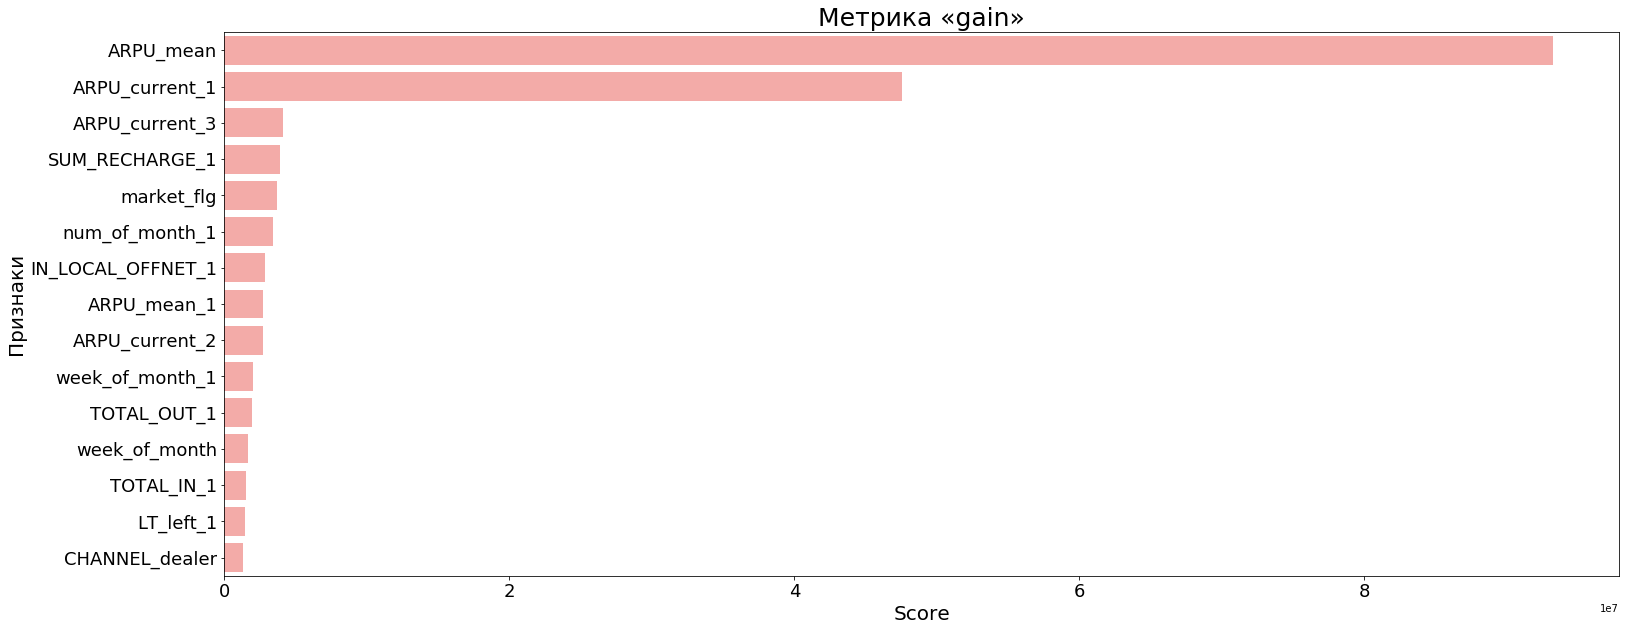

In [58]:
plt.figure(figsize=(25, 10))
sns.set_color_codes("pastel")
ax = sns.barplot(x='Scores', y='Features', data=imp, color='r')
ax.set_ylabel('Признаки', fontsize=20)
ax.set_xlabel('Score', fontsize=20)
ax.set_title('Метрика «gain»', fontsize=25)
ax.tick_params(labelsize=18)

Рассмотим метрики качества

In [18]:
ans_train = best_boost.predict(X_train)
ans_test = best_boost.predict(X_test)
r2_score(y_test, best_boost.predict(X_test))

NameError: name 'X_train' is not defined

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, best_boost.predict(X_train))

208.85538077989017

Рассмотрим отклонение от предсказанной цены

In [65]:
len(chg)

1642484

In [26]:
res = train.copy()
chg = res.copy()
chg.drop(columns=['test_flg'], inplace=True)

In [27]:
chg['market_flg'] = chg['market_flg'].apply(lambda x: 0) 
chg.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
89,4,93.31,1.990586,0,2,6,93.0,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,93.31,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
90,4,93.31,1.990586,0,3,6,93.0,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,93.31,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
91,4,113.31,1.990586,0,4,6,103.0,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,93.31,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,93.0,93.31,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
92,4,157.31,1.990586,0,1,7,135.0,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,113.31,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,103.0,93.31,93.31,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0
93,4,163.31,1.990586,0,2,7,160.0,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,157.31,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,135.0,113.31,93.31,93.31,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [28]:
ans_without_market = best_boost.predict(chg.iloc[:, 2:])
true = np.array(chg.ARPU_current)
diff_true_without_market = true - ans_without_market

In [29]:
res['diff_true_without_market'] = true - diff_true_without_market
res.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,test_flg,diff_true_without_market
89,4,93.31,1.990586,0,2,6,93.0,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,93.31,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,92.452736
90,4,93.31,1.990586,0,3,6,93.0,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,93.31,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,92.656502
91,4,113.31,1.990586,0,4,6,103.0,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,93.31,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,93.0,93.31,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,112.513603
92,4,157.31,1.990586,0,1,7,135.0,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,113.31,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,103.0,93.31,93.31,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,149.691711
93,4,163.31,1.990586,0,2,7,160.0,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,157.31,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,135.0,113.31,93.31,93.31,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,160.665298


Рассмотрим распределение ошибок

In [35]:
tx_revenue =res[:2000].groupby(['SUBSCRIBER_ID'])['error_pred'].agg(['mean']).reset_index()

plt.figure(figsize=(15, 3))
gr = sns.barplot(y='mean',
                x='SUBSCRIBER_ID',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

KeyError: 'Column not found: error_pred'

Рассмотрим пример

Вывод: большую роль играют выбросы 

Рассмотрим влияние маркет. коммуникации

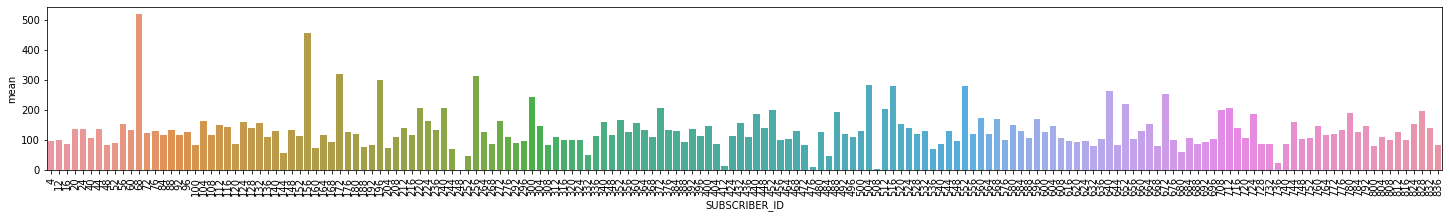

In [30]:
tx_revenue =res[res['market_flg'] == 1][:2000].groupby(['SUBSCRIBER_ID'])['diff_true_without_market'].agg(['mean']).reset_index()

plt.figure(figsize=(25, 3))
gr = sns.barplot(y='mean',
                x='SUBSCRIBER_ID',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

In [31]:
tx_revenue =res[res['market_flg'] == 1][:2000].groupby(['SUBSCRIBER_ID'])['diff_true_without_market'].agg(['mean']).reset_index()

plt.figure(figsize=(25, 3))
gr = sns.barplot(y='mean',
                x='SUBSCRIBER_ID',
                data=tx_revenue)

gr.set_xticklabels(gr.get_xticklabels(),rotation=90)
gr.tick_params(labelsize=10)
plt.show()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,test_flg,diff_true_without_market
89,4,93.31,1.990586,0,2,6,93.0,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,93.31,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,92.452736
90,4,93.31,1.990586,0,3,6,93.0,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,93.31,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,93.0,0.00,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,92.656502
91,4,113.31,1.990586,0,4,6,103.0,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,93.31,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,93.0,93.31,0.00,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,112.513603
92,4,157.31,1.990586,0,1,7,135.0,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,113.31,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,103.0,93.31,93.31,0.00,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,149.691711
93,4,163.31,1.990586,0,2,7,160.0,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,157.31,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,135.0,113.31,93.31,93.31,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,160.665298


In [32]:
res.drop(columns=['test_flg', 'market_flg'], inplace=True)

In [33]:
res.drop(columns=['ARPU_mean', 'ARPU_current_1', 'ARPU_mean_1', 'ARPU_current_2',\
                'ARPU_current_3', 'ARPU_current_4', 'ARPU_current_5'], inplace=True)

In [34]:
res.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,week_of_month,num_of_month,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,diff_true_without_market
89,4,93.31,1.990586,2,6,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0,92.452736
90,4,93.31,1.990586,3,6,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0,92.656502
91,4,113.31,1.990586,4,6,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0,112.513603
92,4,157.31,1.990586,1,7,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0,149.691711
93,4,163.31,1.990586,2,7,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,1,0,1,0,0,0,0,0,0,1,0,0,0,160.665298


Обучим новую модель

In [35]:
X, y = res.iloc[:, 2:len(res.columns) - 1], res['diff_true_without_market']

In [36]:
len(X)

1006015

In [37]:
X.head()

,LT_right,week_of_month,num_of_month,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
89,1.990586,2,6,0.243198,1.942128,-0.473000,0.0,-0.589076,-0.607489,0.373291,0.210122,0.544023,-0.020059,1.000000,0.825226,-0.117100,-0.213874,0.548371,0.010508,0.0,1.0,0.130340,0.310075,-0.635719,1.298029,-0.647323,1.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0
90,1.990586,3,6,-0.043671,1.946532,-0.473000,0.0,-0.589076,-0.607489,0.076640,-0.047793,0.242412,-0.020059,1.000000,-0.455910,-0.049242,-0.518762,0.136088,0.014011,0.0,1.0,-0.272226,-0.150648,-0.643486,0.579230,-0.654014,2.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0
91,1.990586,4,6,0.591540,1.950937,0.592763,2.0,0.477669,0.034777,-0.083812,0.283797,-0.059231,0.467710,0.095238,-0.470381,-0.320671,-0.200247,0.165253,0.013135,0.0,1.0,0.068163,0.238916,-0.647628,0.795010,-0.654014,3.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0
92,1.990586,1,7,0.550568,1.955341,-0.117746,1.0,-0.055704,0.034777,0.473192,0.302229,0.608656,1.451855,0.136905,-0.401510,-0.320671,-0.297760,0.220014,0.015762,0.0,1.0,0.008423,0.162733,-0.649181,0.768871,-0.649382,4.0,6.0,1,0,1,0,0,0,0,0,0,1,0,0,0
93,1.990586,2,7,1.296464,1.959745,0.948017,1.0,1.544414,1.961576,0.809957,1.032699,0.493383,1.227789,0.345238,-0.207025,-0.320671,-0.718474,-0.864301,0.008757,0.0,1.0,-0.443882,-0.670531,-0.665234,-0.632575,-0.654014,1.0,7.0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [38]:
xx_train, xx_test, yy_train, yy_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
models_param_grid = [ 
                    { # 2nd param grid, corresponding to XGBRegressor
                            'learning_rate': [0.1, 0.5],
                            'n_estimators': [300],
                    }]

reg = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

In [40]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1) 

In [41]:
xx_train.head()

,LT_right,week_of_month,num_of_month,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
1250858,0.710307,4,7,-0.136405,0.720253,0.916044,2.0,1.011041,-0.023027,-0.257646,0.197687,-0.720105,0.010218,0.160714,-0.015264,-0.252814,0.654594,-0.900598,0.007881,0.0,1.0,1.031539,1.341469,-0.451378,-0.620341,-0.654014,3.0,7.0,1,0,1,0,0,0,0,0,0,1,0,0,0
1328333,-1.302640,3,8,-0.359679,-1.281181,-0.259848,2.0,-0.322390,-0.543263,-0.336409,-0.470080,-0.132913,0.020897,0.065476,1.945314,-0.320671,-0.793206,-0.883603,0.008757,0.0,1.0,-0.726483,-0.670531,-0.219395,-0.632575,-0.584539,2.0,8.0,0,1,0,1,0,0,0,0,0,1,0,0,0
420669,-0.996732,1,5,-0.271187,-1.015666,0.361919,1.0,0.664456,0.901965,-0.260633,-0.418900,-0.670984,-1.035487,0.779762,-0.288879,0.086472,0.208118,0.424372,0.019264,0.0,1.0,0.499987,0.733124,-0.477786,0.221361,0.972226,5.0,4.0,1,0,0,0,0,0,1,0,0,0,0,1,0
4177343,-1.369360,4,4,-0.287447,-1.396951,0.237508,2.0,0.210983,-0.286356,-0.254245,-0.383942,-0.368307,-0.148770,0.291667,0.327472,2.054329,0.725280,-0.348370,0.053415,0.0,1.0,-0.103251,-0.070000,2.070905,-0.299453,-0.016900,3.0,4.0,1,0,0,0,0,0,0,0,1,1,0,0,0
4302365,-0.457303,4,6,-0.412700,-0.445625,-0.473000,0.0,-0.589076,-0.607489,-0.432115,-0.619086,-0.145581,-0.020059,1.000000,-0.449684,-0.252814,1.050396,2.173794,0.007881,0.0,1.0,1.453611,-0.587931,-0.362831,-0.510783,-0.557777,3.0,6.0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [42]:
clf = GridSearchCV(estimator=reg, param_grid=models_param_grid, cv=inner_cv)
clf.fit(xx_train, yy_train)
clf.best_score_

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\l

0.1402611967151549

Сохраняем модель

In [43]:
best_boost = clf.best_estimator_
pickle.dump(best_boost, open("model_end_last.dat", "wb"))

In [51]:
best_boost = clf.best_estimator_
pickle.dump(best_boost, open("model_last.dat", "wb"))

In [29]:
best_boost = pickle.load(open("model_end_last.dat", "rb"))

In [44]:
clf.best_params_

{'learning_rate': 0.5, 'n_estimators': 300}

<Figure size 1440x576 with 0 Axes>

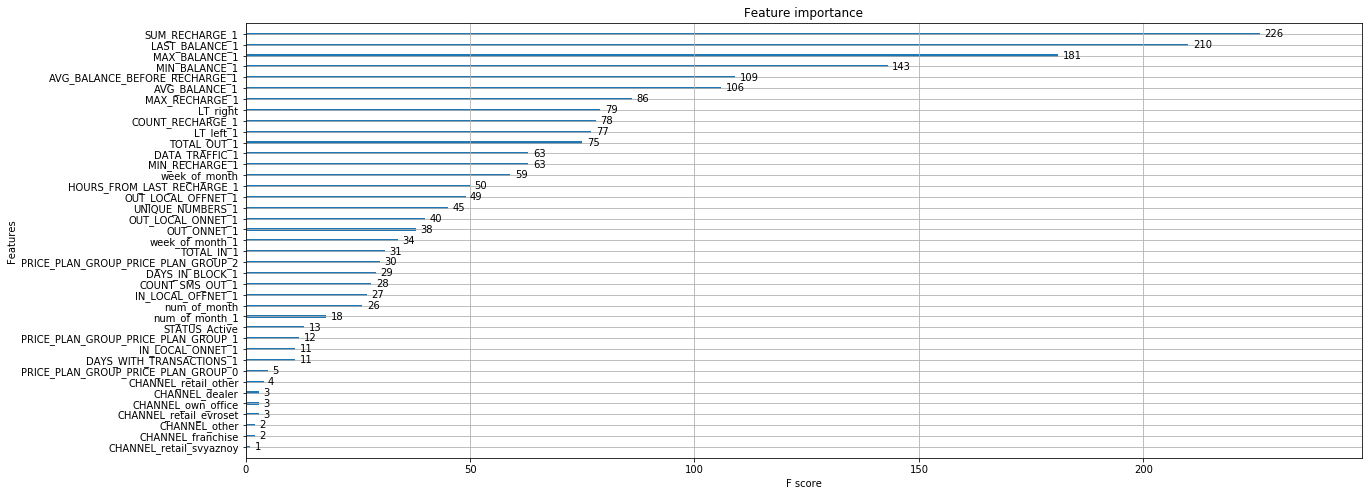

In [45]:
plt.figure(figsize(20,8))
xgb.plot_importance(clf.best_estimator_)

In [46]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
imp = best_boost.get_booster().get_score(importance_type= f)

In [47]:
imp = sorted(imp.items(), key=lambda x:x[1], reverse=True)

In [48]:
y = [imp[i][0] for i in range(len(imp))]
x = [imp[i][1] for i in range(len(imp))]

In [49]:
imp = pd.DataFrame()
imp['Features'] = y[:10]
imp['Scores'] = x[:10]

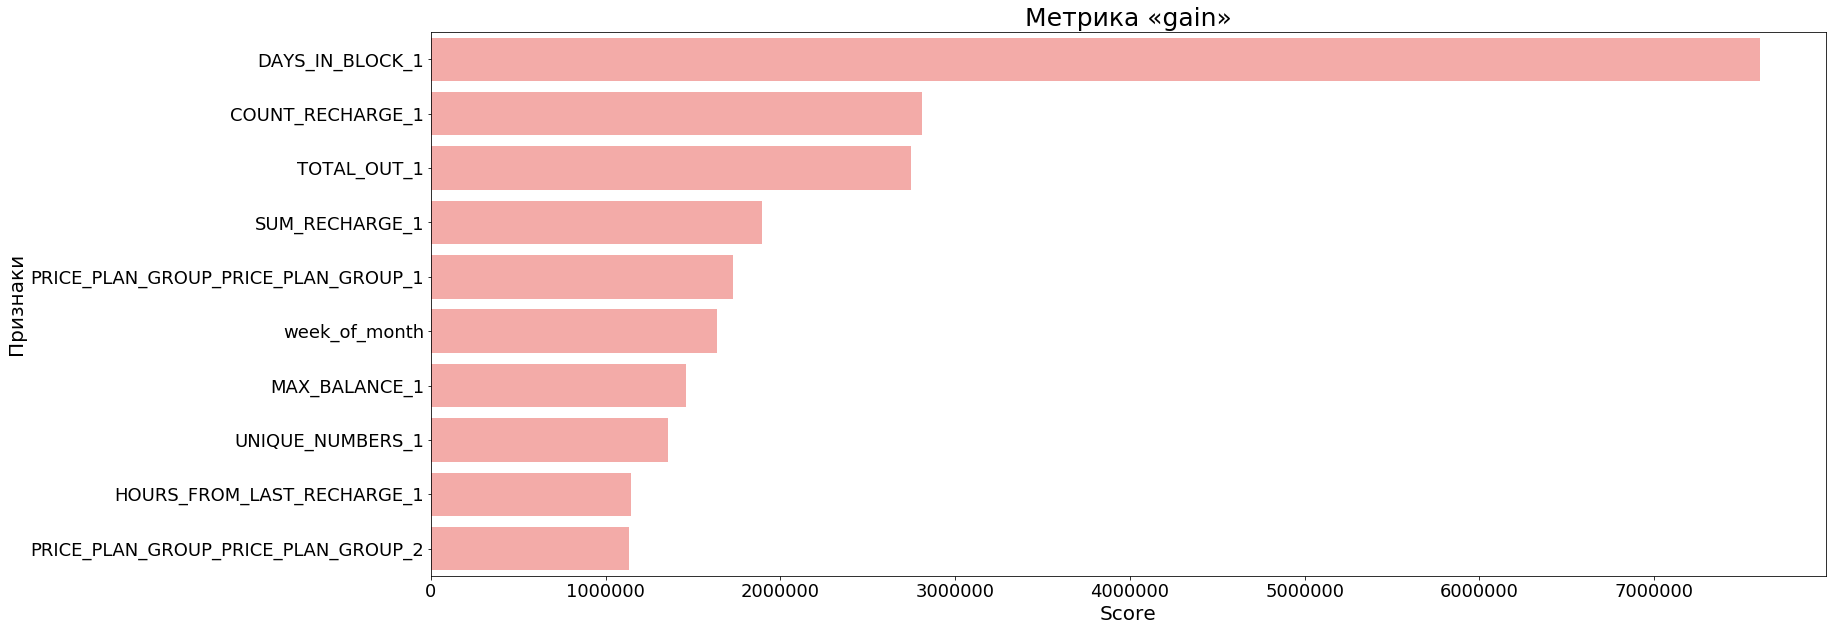

In [50]:
plt.figure(figsize=(25, 10))
sns.set_color_codes("pastel")
ax = sns.barplot(x='Scores', y='Features', data=imp, color='r')
ax.set_ylabel('Признаки', fontsize=20)
ax.set_xlabel('Score', fontsize=20)
ax.set_title('Метрика «gain»', fontsize=25)
ax.tick_params(labelsize=18)

Дерево

In [56]:
xx_train, xx_test, yy_train, yy_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
clf = tree.DecisionTreeRegressor()
parametrs = {'criterion': ['mse'], 'max_depth' : range(2, 5)}

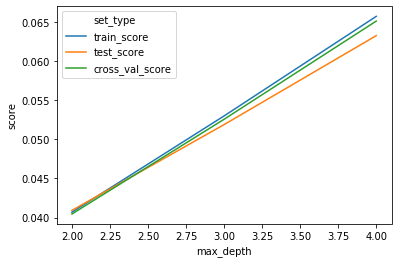

In [42]:
depths = range(2, 5)
scores = pd.DataFrame()

for i in depths:
    clf = tree.DecisionTreeRegressor(criterion='mse', max_depth=i)
    clf.fit(xx_train, yy_train)
    train_score = clf.score(xx_train, yy_train)
    test_score = clf.score(xx_test, yy_test)
    mean_cross_val_score = cross_val_score(clf, xx_train, yy_train, cv=5).mean()
    
    temp = pd.DataFrame({'max_depth':[i], 'train_score':[train_score], 
                         'test_score':[test_score], 'cross_val_score':[mean_cross_val_score]})
    scores = scores.append(temp)
scores.head()
scores = pd.melt(scores, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'], 
                 var_name='set_type', value_name='score')
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores)

In [58]:
GridSearchCV_clf = GridSearchCV(clf, parametrs, cv=3)
GridSearchCV_clf.fit(xx_train, yy_train)
print(GridSearchCV_clf.best_params_)
best_clf = GridSearchCV_clf.best_estimator_

{'criterion': 'mse', 'max_depth': 4}


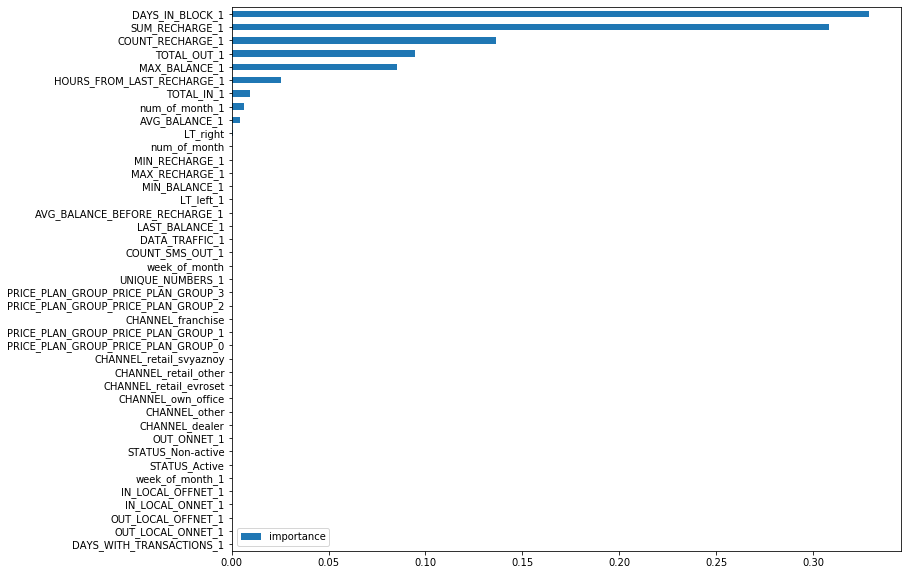

In [59]:
imp = pd.DataFrame(best_clf.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 10))

In [45]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

with open('graph_div.dot', 'w') as file:
    tree.export_graphviz(best_clf, out_file = file,                
                feature_names = X.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

file.close()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Шаг 3. Результат

In [9]:
df = pd.read_csv('df_basis.csv', sep=',')

In [10]:
df['TIME_KEY'] = df['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
pred = df.copy()
pred.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0


In [12]:
pred = pred.set_index('SUBSCRIBER_ID').\
join(need.set_index('SUBSCRIBER_ID'), on='SUBSCRIBER_ID', how='inner', rsuffix='_test').reset_index()

pred = pred.sort_values(['SUBSCRIBER_ID', 'TIME_KEY'], ascending=[True, False])

In [13]:
last_time =pred.groupby(['SUBSCRIBER_ID'])['TIME_KEY'].max().reset_index()

In [14]:
set(need.SUBSCRIBER_ID) - set(last_time.SUBSCRIBER_ID)

set()

In [15]:
len(last_time)

30000

1. Первая недель

In [16]:
pred = pred.set_index(['SUBSCRIBER_ID', 'TIME_KEY']).\
join(last_time.set_index(['SUBSCRIBER_ID', 'TIME_KEY']), on=['SUBSCRIBER_ID', 'TIME_KEY'], \
     how='inner', rsuffix='_1').reset_index()

In [17]:
pred.TIME_KEY = pred.TIME_KEY.apply(lambda x: x  + timedelta(days=7))

In [18]:
pred.LT_left = pred.LT_left.apply(lambda x: x  + 7)

In [26]:
pred = pred.sort_values(['SUBSCRIBER_ID'], ascending=[True])
pred['ARPU'] = week_4
pred.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP
0,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,110.460602,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.8500,14,0,7,35.9333,35.9333,0.2667,127.3500,0.7500,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0
1,6,2018-10-15,51.89,5469,300.0,1,300.0,300.0,426.146362,106.75,185.89,-248.11,-248.11,64,115061760,3,100.8667,62.5500,26,0,7,8.8667,8.8667,82.2167,47.2333,15.3167,2016-10-21 00:00:00,Active,5377.0,2017-09-19 15:59:54,dealer,PRICE_PLAN_GROUP_2
2,8,2018-10-15,94.35,5810,0.0,0,0.0,0.0,1.649905,94.35,94.35,94.35,0.00,168,82275328,0,100.4667,73.3500,11,0,7,82.9333,82.9333,17.5333,61.0167,12.1333,2017-09-15 00:00:00,Active,5718.0,2018-06-01 22:49:43,dealer,PRICE_PLAN_GROUP_2
3,10,2018-10-15,-119.85,4081,0.0,0,0.0,0.0,262.598419,18.25,128.71,-119.85,0.00,168,4411066368,130,200.1667,250.4833,15,0,7,145.1667,123.2167,16.4500,0.0000,0.0000,2017-11-28 00:00:00,Active,3999.0,2018-04-09 01:10:57,dealer,PRICE_PLAN_GROUP_1
4,12,2018-10-15,28.70,1978,0.0,0,0.0,0.0,128.882187,83.85,156.70,28.70,0.00,168,1493896192,0,155.0000,93.8833,27,0,7,151.0000,150.8667,3.9500,82.5667,11.2833,2018-01-12 00:00:00,Active,1886.0,2016-10-01 13:36:02,retail_evroset,PRICE_PLAN_GROUP_0


In [27]:
print(len(pred))
pred.to_csv('_week_full.csv', index=False)

30000


In [28]:
df = df.append(pred, ignore_index=True).sort_values(['SUBSCRIBER_ID', 'TIME_KEY'], ascending=[True, True])

In [29]:
df[df['SUBSCRIBER_ID'] == 4].tail()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP
107,4,2018-09-17,561.82,6005,300.0,1,300.0,300.0,105.810000,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0
108,4,2018-09-24,561.82,6012,300.0,1,300.0,300.0,109.878433,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0
109,4,2018-10-01,561.82,6019,300.0,1,300.0,300.0,109.263161,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0
110,4,2018-10-08,561.82,6026,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0
5360704,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,110.460602,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0


In [30]:
len(df)

5390704

In [31]:
df.to_csv('df_basis.csv', index=False)

In [19]:
pred['test_flg'] = pred.LT_left.apply(lambda x: 1)
pred.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg
0,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.8500,14,0,7,35.9333,35.9333,0.2667,127.3500,0.7500,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,1
1,6,2018-10-15,51.89,5469,300.0,1,300.0,300.0,422.070831,106.75,185.89,-248.11,-248.11,64,115061760,3,100.8667,62.5500,26,0,7,8.8667,8.8667,82.2167,47.2333,15.3167,2016-10-21 00:00:00,Active,5377.0,2017-09-19 15:59:54,dealer,PRICE_PLAN_GROUP_2,1
2,8,2018-10-15,94.35,5810,0.0,0,0.0,0.0,1.466077,94.35,94.35,94.35,0.00,168,82275328,0,100.4667,73.3500,11,0,7,82.9333,82.9333,17.5333,61.0167,12.1333,2017-09-15 00:00:00,Active,5718.0,2018-06-01 22:49:43,dealer,PRICE_PLAN_GROUP_2,1
3,10,2018-10-15,-119.85,4081,0.0,0,0.0,0.0,272.208008,18.25,128.71,-119.85,0.00,168,4411066368,130,200.1667,250.4833,15,0,7,145.1667,123.2167,16.4500,0.0000,0.0000,2017-11-28 00:00:00,Active,3999.0,2018-04-09 01:10:57,dealer,PRICE_PLAN_GROUP_1,1
4,12,2018-10-15,28.70,1978,0.0,0,0.0,0.0,128.841034,83.85,156.70,28.70,0.00,168,1493896192,0,155.0000,93.8833,27,0,7,151.0000,150.8667,3.9500,82.5667,11.2833,2018-01-12 00:00:00,Active,1886.0,2016-10-01 13:36:02,retail_evroset,PRICE_PLAN_GROUP_0,1


In [21]:
pred.to_csv('pred_four_week.csv', index=False)

In [22]:
pred = pd.read_csv('pred_four_week.csv', sep=',')
pred['TIME_KEY'] = pred['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
pred.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg
0,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.8500,14,0,7,35.9333,35.9333,0.2667,127.3500,0.7500,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,1
1,6,2018-10-15,51.89,5469,300.0,1,300.0,300.0,422.070831,106.75,185.89,-248.11,-248.11,64,115061760,3,100.8667,62.5500,26,0,7,8.8667,8.8667,82.2167,47.2333,15.3167,2016-10-21 00:00:00,Active,5377.0,2017-09-19 15:59:54,dealer,PRICE_PLAN_GROUP_2,1
2,8,2018-10-15,94.35,5810,0.0,0,0.0,0.0,1.466077,94.35,94.35,94.35,0.00,168,82275328,0,100.4667,73.3500,11,0,7,82.9333,82.9333,17.5333,61.0167,12.1333,2017-09-15 00:00:00,Active,5718.0,2018-06-01 22:49:43,dealer,PRICE_PLAN_GROUP_2,1
3,10,2018-10-15,-119.85,4081,0.0,0,0.0,0.0,272.208008,18.25,128.71,-119.85,0.00,168,4411066368,130,200.1667,250.4833,15,0,7,145.1667,123.2167,16.4500,0.0000,0.0000,2017-11-28 00:00:00,Active,3999.0,2018-04-09 01:10:57,dealer,PRICE_PLAN_GROUP_1,1
4,12,2018-10-15,28.70,1978,0.0,0,0.0,0.0,128.841034,83.85,156.70,28.70,0.00,168,1493896192,0,155.0000,93.8833,27,0,7,151.0000,150.8667,3.9500,82.5667,11.2833,2018-01-12 00:00:00,Active,1886.0,2016-10-01 13:36:02,retail_evroset,PRICE_PLAN_GROUP_0,1


У нас есть данные несколько маркетинговых коммуникаций (дата сбора профиля - дата маркетинговой коммуникации)

In [23]:
df['test_flg'] = df.LT_left.apply(lambda x: 0)

In [24]:
df = df.append(pred, ignore_index=True).sort_values(['SUBSCRIBER_ID', 'TIME_KEY'], ascending=[True, True])
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0


In [26]:
df[df['SUBSCRIBER_ID'] == 4].sort_values(['TIME_KEY'], ascending=[False]).head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg
5360704,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,1
110,4,2018-10-08,561.82,6026,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0
109,4,2018-10-01,561.82,6019,300.0,1,300.0,300.0,109.263161,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0
108,4,2018-09-24,561.82,6012,300.0,1,300.0,300.0,109.878433,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0
107,4,2018-09-17,561.82,6005,300.0,1,300.0,300.0,105.810000,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0


In [25]:
len(df)

5390704

#### 1. Рассмотрим данные по марк.ком ( марк.ком = тест). Определяем даты тестов

In [16]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0


In [27]:
df['market_flg'] = df['LT_left'] - df['LT_right']
df['market_flg'] = df['market_flg'].apply(lambda x: 1 if x >=0 else 0)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0


#### 2. Добавим фичи на основе времени

In [28]:
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0)) - 1

In [29]:
df['week_of_month'] = df['TIME_KEY'].apply(lambda x: week_of_month(x))

In [30]:
df['num_of_month'] = df['TIME_KEY'].apply(lambda x: x.month)

In [31]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,1,5
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,2,5
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,3,5
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,4,5
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,1,6


In [32]:
len(df)

5390704

#### 3. Добавляем среднее до момента наблюдения

In [33]:
means = df[['SUBSCRIBER_ID', 'TIME_KEY', 'ARPU']]
means.ARPU = means.ARPU.apply(lambda x: int(round(x)))
means.head()

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,SUBSCRIBER_ID,TIME_KEY,ARPU
0,0,2018-05-07,82
1,0,2018-05-14,82
2,0,2018-05-21,82
3,0,2018-05-28,132
4,0,2018-06-04,82


In [34]:
means_col = means.groupby(['SUBSCRIBER_ID']).rolling('10D', on='TIME_KEY').mean().reset_index(drop=True)

In [35]:
means_col.to_csv('means_col_four_week.csv', index=False)
means_col.head()

,SUBSCRIBER_ID,TIME_KEY,ARPU
0,0.0,2018-05-07,82.0
1,0.0,2018-05-14,82.0
2,0.0,2018-05-21,82.0
3,0.0,2018-05-28,107.0
4,0.0,2018-06-04,107.0


In [36]:
means_col = pd.read_csv('means_col_four_week.csv', sep=',')
means_col['TIME_KEY'] = means_col['TIME_KEY'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
means_col.head()

,SUBSCRIBER_ID,TIME_KEY,ARPU
0,0.0,2018-05-07,82.0
1,0.0,2018-05-14,82.0
2,0.0,2018-05-21,82.0
3,0.0,2018-05-28,107.0
4,0.0,2018-06-04,107.0


In [37]:
len(means_col)

5390704

In [38]:
df = df.set_index(['SUBSCRIBER_ID', 'TIME_KEY'])\
    .join(means_col.set_index(['SUBSCRIBER_ID', 'TIME_KEY']), on=['SUBSCRIBER_ID', 'TIME_KEY'], how='inner', lsuffix='_current', rsuffix='_mean').reset_index()
df = df.sort_values(['SUBSCRIBER_ID', 'TIME_KEY'], ascending=[True, True])
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,278.29,4982,0.0,0,0.0,0.0,81.69,313.29,354.13,278.29,0.00,168,728403968,0,77.2833,60.4167,25,0,7,24.4667,24.4667,52.5500,13.7333,32.3667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,1,5,82.0
1,0,2018-05-14,377.73,4989,181.1,2,91.0,90.1,81.69,296.50,377.73,231.63,259.63,10,401867776,0,74.7667,84.8667,25,0,7,39.9167,35.9833,34.7333,4.1500,66.4333,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0
2,0,2018-05-21,296.06,4996,0.0,0,0.0,0.0,81.69,331.06,371.90,296.06,0.00,168,696773632,2,87.1000,85.5833,35,0,7,32.9167,27.1500,53.9833,21.2167,52.3000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0
3,0,2018-05-28,164.39,5003,0.0,0,0.0,0.0,131.69,213.68,290.23,164.39,0.00,168,1039864832,0,73.7333,69.6167,30,0,7,37.2667,37.2667,36.2500,22.5333,46.8667,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0
4,0,2018-06-04,262.93,5010,180.2,1,180.2,180.2,81.69,297.93,332.93,152.73,152.73,156,395038720,0,129.0667,97.3667,35,0,7,81.7333,81.7333,47.1833,34.6667,56.2000,2018-02-09 00:00:00,Active,5050.0,2017-09-30 21:51:15,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0


In [39]:
df[df['SUBSCRIBER_ID'] == 4].sort_values(['TIME_KEY'], ascending=[False]).head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,PRICE_PLAN_CHANGE_DATE,STATUS,LT_right,LAST_DEVICE_CHANGE_DATE,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean
111,4,2018-10-15,561.82,6033,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,1,1,2,10,110.0
110,4,2018-10-08,561.82,6026,300.0,1,300.0,300.0,109.581573,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0,1,1,10,109.5
109,4,2018-10-01,561.82,6019,300.0,1,300.0,300.0,109.263161,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0,1,0,10,109.5
108,4,2018-09-24,561.82,6012,300.0,1,300.0,300.0,109.878433,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0,1,4,9,108.0
107,4,2018-09-17,561.82,6005,300.0,1,300.0,300.0,105.810000,478.61,601.82,301.82,301.82,78,958200832,11,45.4167,128.85,14,0,7,35.9333,35.9333,0.2667,127.35,0.75,2018-05-29 00:00:00,Active,5970.0,2017-10-09 09:43:06,dealer,PRICE_PLAN_GROUP_0,0,1,3,9,99.5


In [40]:
len(set(df.SUBSCRIBER_ID))

232751

#### 4. Нормализируем данные

In [41]:
df.columns

Index(['SUBSCRIBER_ID', 'TIME_KEY', 'LAST_BALANCE', 'LT_left', 'SUM_RECHARGE', 'COUNT_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'ARPU_current', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', 'AVG_BALANCE_BEFORE_RECHARGE', 'HOURS_FROM_LAST_RECHARGE', 'DATA_TRAFFIC', 'COUNT_SMS_OUT', 'TOTAL_OUT', 'TOTAL_IN', 'UNIQUE_NUMBERS', 'DAYS_IN_BLOCK', 'DAYS_WITH_TRANSACTIONS', 'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'PRICE_PLAN_CHANGE_DATE', 'STATUS', 'LT_right', 'LAST_DEVICE_CHANGE_DATE', 'CHANNEL', 'PRICE_PLAN_GROUP', 'test_flg', 'market_flg', 'week_of_month', 'num_of_month', 'ARPU_mean'], dtype='object')

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
for x in ['LAST_BALANCE', 'SUM_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', \
         'AVG_BALANCE_BEFORE_RECHARGE', 'DATA_TRAFFIC', 'TOTAL_OUT', 'TOTAL_IN', 'COUNT_SMS_OUT',\
         'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'LT_right', 'LT_left']:
    tr = scaler.fit_transform(df[x].values.reshape(-1, 1))
    df[x] = tr
    
scaler = MinMaxScaler()
for x in ['HOURS_FROM_LAST_RECHARGE', 'UNIQUE_NUMBERS', 'DAYS_WITH_TRANSACTIONS', 'DAYS_IN_BLOCK']:
    tr = scaler.fit_transform(df[x].values.reshape(-1, 1))
    df[x] = tr 
    
df.drop(columns=['PRICE_PLAN_CHANGE_DATE', 'LAST_DEVICE_CHANGE_DATE'], inplace=True)    
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,0.440350,1.357004,-0.473808,0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,5,82.0
1,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0
2,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0
3,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0
4,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0


#### 5. Прикрепим данные за последний период

In [43]:
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,2018-05-07,0.440350,1.357004,-0.473808,0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,5,82.0
1,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0
2,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0
3,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0
4,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0


In [44]:
df.shift(1).head().reset_index()

,index,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean
0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0
2,2,0.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0
3,3,0.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0
4,4,0.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0


1 week

In [45]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df.shift(1).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='inner', rsuffix='_1').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0


In [46]:
len(df)

5157953

2 week

In [47]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(2).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_2').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0,NaN
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0,NaN
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0,81.69
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0,81.69
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0,131.69


In [48]:
len(df)

5157953

3 week

In [49]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(3).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_3').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0,NaN,NaN
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0,NaN,NaN
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0,81.69,NaN
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0,81.69,81.69
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0,131.69,81.69


In [50]:
len(df)

5157953

4 week

In [51]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(4).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_4').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0,NaN,NaN,NaN
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0,NaN,NaN,NaN
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0,81.69,NaN,NaN
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0,81.69,81.69,NaN
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0,131.69,81.69,81.69


In [52]:
len(df)

5157953

5 week

In [53]:
df = df.reset_index().set_index(['index', 'SUBSCRIBER_ID'])\
    .join(df[['ARPU_current', 'SUBSCRIBER_ID']].shift(5).reset_index().set_index(['index', 'SUBSCRIBER_ID']), on=['index', 'SUBSCRIBER_ID'], \
    how='left', rsuffix='_5').reset_index()

df.drop(columns=['index'], inplace=True)
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0,NaN,NaN,NaN,NaN
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0,NaN,NaN,NaN,NaN
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0,81.69,NaN,NaN,NaN
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0,81.69,81.69,NaN,NaN
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0,131.69,81.69,81.69,NaN


In [54]:
len(df)

5157953

#### 6. См. на пропуски данных

In [55]:
df.isnull().sum()

SUBSCRIBER_ID                          0
TIME_KEY                               0
LAST_BALANCE                           0
LT_left                                0
SUM_RECHARGE                           0
COUNT_RECHARGE                         0
MAX_RECHARGE                           0
MIN_RECHARGE                           0
ARPU_current                           0
AVG_BALANCE                            0
MAX_BALANCE                            0
MIN_BALANCE                            0
AVG_BALANCE_BEFORE_RECHARGE            0
HOURS_FROM_LAST_RECHARGE               0
DATA_TRAFFIC                           0
COUNT_SMS_OUT                          0
TOTAL_OUT                              0
TOTAL_IN                               0
UNIQUE_NUMBERS                         0
DAYS_IN_BLOCK                          0
DAYS_WITH_TRANSACTIONS                 0
OUT_ONNET                              0
OUT_LOCAL_ONNET                        0
OUT_LOCAL_OFFNET                       0
IN_LOCAL_ONNET  

In [56]:
df.fillna(0, inplace=True)

In [57]:
df.columns

Index(['SUBSCRIBER_ID', 'TIME_KEY', 'LAST_BALANCE', 'LT_left', 'SUM_RECHARGE', 'COUNT_RECHARGE', 'MAX_RECHARGE', 'MIN_RECHARGE', 'ARPU_current', 'AVG_BALANCE', 'MAX_BALANCE', 'MIN_BALANCE', 'AVG_BALANCE_BEFORE_RECHARGE', 'HOURS_FROM_LAST_RECHARGE', 'DATA_TRAFFIC', 'COUNT_SMS_OUT', 'TOTAL_OUT', 'TOTAL_IN', 'UNIQUE_NUMBERS', 'DAYS_IN_BLOCK', 'DAYS_WITH_TRANSACTIONS', 'OUT_ONNET', 'OUT_LOCAL_ONNET', 'OUT_LOCAL_OFFNET', 'IN_LOCAL_ONNET', 'IN_LOCAL_OFFNET', 'STATUS', 'LT_right', 'CHANNEL', 'PRICE_PLAN_GROUP', 'test_flg', 'market_flg', 'week_of_month', 'num_of_month', 'ARPU_mean', 'TIME_KEY_1', 'LAST_BALANCE_1', 'LT_left_1', 'SUM_RECHARGE_1', 'COUNT_RECHARGE_1', 'MAX_RECHARGE_1', 'MIN_RECHARGE_1', 'ARPU_current_1', 'AVG_BALANCE_1', 'MAX_BALANCE_1', 'MIN_BALANCE_1', 'AVG_BALANCE_BEFORE_RECHARGE_1', 'HOURS_FROM_LAST_RECHARGE_1', 'DATA_TRAFFIC_1', 'COUNT_SMS_OUT_1', 'TOTAL_OUT_1', 'TOTAL_IN_1', 'UNIQUE_NUMBERS_1', 'DAYS_IN_BLOCK_1', 'DAYS_WITH_TRANSACTIONS_1', 'OUT_ONNET_1',
       'OUT_LOCAL_O

In [58]:
test_flg = df['test_flg']
df.drop(columns=['test_flg', 'test_flg_1'])
df.head()

,SUBSCRIBER_ID,TIME_KEY,LAST_BALANCE,LT_left,SUM_RECHARGE,COUNT_RECHARGE,MAX_RECHARGE,MIN_RECHARGE,ARPU_current,AVG_BALANCE,MAX_BALANCE,MIN_BALANCE,AVG_BALANCE_BEFORE_RECHARGE,HOURS_FROM_LAST_RECHARGE,DATA_TRAFFIC,COUNT_SMS_OUT,TOTAL_OUT,TOTAL_IN,UNIQUE_NUMBERS,DAYS_IN_BLOCK,DAYS_WITH_TRANSACTIONS,OUT_ONNET,OUT_LOCAL_ONNET,OUT_LOCAL_OFFNET,IN_LOCAL_ONNET,IN_LOCAL_OFFNET,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,test_flg,market_flg,week_of_month,num_of_month,ARPU_mean,TIME_KEY_1,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,STATUS_1,LT_right_1,CHANNEL_1,PRICE_PLAN_GROUP_1,test_flg_1,market_flg_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5
0,0,2018-05-14,0.746432,1.361409,0.171008,2,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,5,82.0,2018-05-07,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,5.0,82.0,0.00,0.00,0.00,0.0
1,0,2018-05-21,0.495047,1.365814,-0.473808,0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,3,5,82.0,2018-05-14,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,2.0,5.0,82.0,0.00,0.00,0.00,0.0
2,0,2018-05-28,0.089758,1.370219,-0.473808,0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,4,5,107.0,2018-05-21,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,3.0,5.0,82.0,81.69,0.00,0.00,0.0
3,0,2018-06-04,0.393070,1.374625,0.167803,1,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,1,6,107.0,2018-05-28,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,4.0,5.0,107.0,81.69,81.69,0.00,0.0
4,0,2018-06-11,0.141685,1.379030,-0.473808,0,-0.588429,-0.606529,81.69,0.252362,0.088667,0.437618,-0.020519,1.000000,-0.183164,-0.253083,0.429092,0.493736,0.033275,0.0,1.0,0.525342,0.761703,0.100923,0.213995,1.057056,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,0,2,6,82.0,2018-06-04,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0.0,0.0,1.0,6.0,107.0,131.69,81.69,81.69,0.0


In [59]:
len(test_flg)

5157953

In [60]:
df = df[[
    
    'SUBSCRIBER_ID',
    #
    'ARPU_current',
    #
    'STATUS', 'LT_right', 'CHANNEL', 'PRICE_PLAN_GROUP', 'market_flg', 
    
    'week_of_month', 'num_of_month', 'ARPU_mean', 
    
    'LAST_BALANCE_1', 'LT_left_1', 'SUM_RECHARGE_1', 'COUNT_RECHARGE_1', 'MAX_RECHARGE_1', 
    'MIN_RECHARGE_1', 'ARPU_current_1', 'AVG_BALANCE_1', 'MAX_BALANCE_1', 'MIN_BALANCE_1', 'AVG_BALANCE_BEFORE_RECHARGE_1',
    'HOURS_FROM_LAST_RECHARGE_1', 'DATA_TRAFFIC_1', 'COUNT_SMS_OUT_1', 'TOTAL_OUT_1', 'TOTAL_IN_1', 'UNIQUE_NUMBERS_1', 
    'DAYS_IN_BLOCK_1', 'DAYS_WITH_TRANSACTIONS_1', 'OUT_ONNET_1', 'OUT_LOCAL_ONNET_1', 'OUT_LOCAL_OFFNET_1', 
    'IN_LOCAL_ONNET_1', 'IN_LOCAL_OFFNET_1', 
    
    'week_of_month_1', 'num_of_month_1', 'ARPU_mean_1', 
    'ARPU_current_2', 'ARPU_current_3', 'ARPU_current_4', 'ARPU_current_5']]

In [48]:
df.to_csv('df_pred.csv', index=False)

In [17]:
df = pd.read_csv('df_pred.csv', sep=',')

In [61]:
df.head()

,SUBSCRIBER_ID,ARPU_current,STATUS,LT_right,CHANNEL,PRICE_PLAN_GROUP,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5
0,0,81.69,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,2,5,82.0,0.440350,1.357004,-0.473808,0.0,-0.588429,-0.606529,81.69,0.561305,0.357182,0.751809,-0.020519,1.000000,-0.068539,-0.321075,0.008465,-0.151984,0.021891,0.0,1.0,-0.368546,-0.261098,0.968437,-0.403991,0.344927,1.0,5.0,82.0,0.00,0.00,0.00,0.0
1,0,81.69,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,3,5,82.0,0.746432,1.361409,0.171008,2.0,-0.103214,-0.028384,81.69,0.507846,0.422491,0.600720,1.617338,0.059524,-0.277619,-0.321075,-0.023677,0.155872,0.021891,0.0,1.0,-0.142514,-0.068313,0.414450,-0.563911,1.396656,2.0,5.0,82.0,0.00,0.00,0.00,0.0
2,0,131.69,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,4,5,107.0,0.495047,1.365814,-0.473808,0.0,-0.588429,-0.606529,81.69,0.617885,0.406358,0.809349,-0.020519,1.000000,-0.088791,-0.185090,0.133844,0.164895,0.030648,0.0,1.0,-0.244923,-0.216180,1.013004,-0.279114,0.960322,3.0,5.0,82.0,81.69,0.00,0.00,0.0
3,0,81.69,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,1,6,107.0,0.089758,1.370219,-0.473808,0.0,-0.588429,-0.606529,131.69,0.244148,0.180349,0.382991,-0.020519,1.000000,0.130889,-0.321075,-0.036876,-0.036145,0.026270,0.0,1.0,-0.181283,-0.046829,0.461610,-0.257143,0.792582,4.0,5.0,107.0,81.69,81.69,0.00,0.0
4,0,81.69,Active,1.405347,dealer,PRICE_PLAN_GROUP_0,0,2,6,82.0,0.393070,1.374625,0.167803,1.0,0.372404,0.549760,81.69,0.512399,0.298514,0.345235,0.942967,0.928571,-0.281991,-0.321075,0.669845,0.313262,0.030648,0.0,1.0,0.469260,0.697532,0.801567,-0.054670,1.080726,1.0,6.0,107.0,131.69,81.69,81.69,0.0


In [62]:
df['test_flg'] = test_flg

In [63]:
df = pd.get_dummies(df)

In [64]:
need_pred = df[df['test_flg'] == 1]

In [65]:
len(set(need_pred.SUBSCRIBER_ID))

30000

In [66]:
sub = need_pred.SUBSCRIBER_ID
X = need_pred.iloc[:, 2:]
X.drop(columns=['test_flg'], inplace=True)
X.head()

,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3
106,1.984702,1,2,10,110.0,1.313073,2.013996,0.594357,1.0,1.011182,1.318481,109.581573,1.087683,1.042624,0.828000,1.883490,0.464286,0.078600,0.426842,-0.398537,0.709676,0.012259,0.0,1.0,-0.200790,-0.069150,-0.657244,1.491961,-0.631167,1.0,10.0,109.5,109.263161,109.878433,105.81,93.31,1,0,1,0,0,0,0,0,0,1,0,0,0
151,1.611270,1,2,10,422.0,-0.256524,1.659069,0.594357,1.0,1.011182,1.318481,422.070831,-0.096317,-0.108395,-0.952716,-1.585703,0.380952,-0.461260,-0.117098,0.309673,-0.125123,0.022767,0.0,1.0,-0.596773,-0.522239,1.890885,0.155032,-0.181453,1.0,10.0,423.0,424.255188,449.673920,434.00,66.00,1,0,1,0,0,0,0,0,0,0,0,1,0
194,1.826009,1,2,10,1.0,-0.125830,1.873662,-0.473808,0.0,-0.588429,-0.606529,1.466077,-0.135798,-0.361718,0.156196,-0.020519,1.000000,-0.482253,-0.321075,0.304564,0.010862,0.009632,0.0,1.0,0.486816,0.717620,-0.120361,0.385040,-0.279734,1.0,10.0,1.0,0.779638,0.547476,0.00,352.00,1,0,1,0,0,0,0,0,0,0,0,1,0
238,0.743497,1,2,10,272.0,-0.785151,0.785597,-0.473808,0.0,-0.588429,-0.606529,272.208008,-0.378100,-0.266632,-0.537400,-0.020519,1.000000,2.289459,8.517949,1.577937,2.241190,0.013135,0.0,1.0,1.397286,1.391956,-0.154045,-0.633163,-0.654322,1.0,10.0,262.5,253.278214,254.954727,258.55,161.00,1,0,1,0,0,0,0,0,0,0,1,0,0
284,-0.587130,1,2,10,129.0,-0.327905,-0.537827,-0.473808,0.0,-0.588429,-0.606529,128.841034,-0.169230,-0.189174,-0.056383,-0.020519,1.000000,0.421604,-0.321075,1.001066,0.269402,0.023643,0.0,1.0,1.482626,1.854811,-0.542717,0.744650,-0.305975,1.0,10.0,128.0,127.028122,127.859962,128.01,116.69,1,0,0,0,0,0,1,0,0,1,0,0,0


In [69]:
need_pred_ans = best_boost.predict(X)

In [70]:
need_pred['SUBSCRIBER_ID'] = sub
need_pred['ARPU_next_week'] = need_pred_ans

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
need_pred.head()

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,test_flg,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,ARPU_next_week
106,4,109.581573,1.984702,1,2,10,110.0,1.313073,2.013996,0.594357,1.0,1.011182,1.318481,109.581573,1.087683,1.042624,0.828000,1.883490,0.464286,0.078600,0.426842,-0.398537,0.709676,0.012259,0.0,1.0,-0.200790,-0.069150,-0.657244,1.491961,-0.631167,1.0,10.0,109.5,109.263161,109.878433,105.81,93.31,1,1,0,1,0,0,0,0,0,0,1,0,0,0,110.460602
151,6,422.070831,1.611270,1,2,10,422.0,-0.256524,1.659069,0.594357,1.0,1.011182,1.318481,422.070831,-0.096317,-0.108395,-0.952716,-1.585703,0.380952,-0.461260,-0.117098,0.309673,-0.125123,0.022767,0.0,1.0,-0.596773,-0.522239,1.890885,0.155032,-0.181453,1.0,10.0,423.0,424.255188,449.673920,434.00,66.00,1,1,0,1,0,0,0,0,0,0,0,0,1,0,426.146362
194,8,1.466077,1.826009,1,2,10,1.0,-0.125830,1.873662,-0.473808,0.0,-0.588429,-0.606529,1.466077,-0.135798,-0.361718,0.156196,-0.020519,1.000000,-0.482253,-0.321075,0.304564,0.010862,0.009632,0.0,1.0,0.486816,0.717620,-0.120361,0.385040,-0.279734,1.0,10.0,1.0,0.779638,0.547476,0.00,352.00,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1.649905
238,10,272.208008,0.743497,1,2,10,272.0,-0.785151,0.785597,-0.473808,0.0,-0.588429,-0.606529,272.208008,-0.378100,-0.266632,-0.537400,-0.020519,1.000000,2.289459,8.517949,1.577937,2.241190,0.013135,0.0,1.0,1.397286,1.391956,-0.154045,-0.633163,-0.654322,1.0,10.0,262.5,253.278214,254.954727,258.55,161.00,1,1,0,1,0,0,0,0,0,0,0,1,0,0,262.598419
284,12,128.841034,-0.587130,1,2,10,129.0,-0.327905,-0.537827,-0.473808,0.0,-0.588429,-0.606529,128.841034,-0.169230,-0.189174,-0.056383,-0.020519,1.000000,0.421604,-0.321075,1.001066,0.269402,0.023643,0.0,1.0,1.482626,1.854811,-0.542717,0.744650,-0.305975,1.0,10.0,128.0,127.028122,127.859962,128.01,116.69,1,1,0,0,0,0,0,1,0,0,1,0,0,0,128.882187


In [72]:
len(need_pred)

30000

Вклинияваем в данные

In [73]:
need_pred = need_pred.sort_values(['SUBSCRIBER_ID'], ascending=[True])
len(set(need.SUBSCRIBER_ID)) - len(set(need_pred.SUBSCRIBER_ID))

0

Дополнительно

In [74]:
need_pred[need_pred['ARPU_next_week'] < 0]

,SUBSCRIBER_ID,ARPU_current,LT_right,market_flg,week_of_month,num_of_month,ARPU_mean,LAST_BALANCE_1,LT_left_1,SUM_RECHARGE_1,COUNT_RECHARGE_1,MAX_RECHARGE_1,MIN_RECHARGE_1,ARPU_current_1,AVG_BALANCE_1,MAX_BALANCE_1,MIN_BALANCE_1,AVG_BALANCE_BEFORE_RECHARGE_1,HOURS_FROM_LAST_RECHARGE_1,DATA_TRAFFIC_1,COUNT_SMS_OUT_1,TOTAL_OUT_1,TOTAL_IN_1,UNIQUE_NUMBERS_1,DAYS_IN_BLOCK_1,DAYS_WITH_TRANSACTIONS_1,OUT_ONNET_1,OUT_LOCAL_ONNET_1,OUT_LOCAL_OFFNET_1,IN_LOCAL_ONNET_1,IN_LOCAL_OFFNET_1,week_of_month_1,num_of_month_1,ARPU_mean_1,ARPU_current_2,ARPU_current_3,ARPU_current_4,ARPU_current_5,test_flg,STATUS_Active,STATUS_Non-active,CHANNEL_dealer,CHANNEL_franchise,CHANNEL_other,CHANNEL_own_office,CHANNEL_retail_evroset,CHANNEL_retail_other,CHANNEL_retail_svyaznoy,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_0,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_1,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_2,PRICE_PLAN_GROUP_PRICE_PLAN_GROUP_3,ARPU_next_week
39124,1766,0.000000,-0.718114,1,2,10,0.0,-0.847020,-0.668093,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.881808,-1.010105,-0.602485,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000000,1.000000,0.000000,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.000000,0.384219,0.00,0.00,1,1,0,0,0,0,1,0,0,0,0,0,1,0,-0.047971
64924,2929,0.000000,-1.225680,1,2,10,0.0,-0.956568,-1.175311,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.995126,-1.108595,-0.717728,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000876,1.000000,0.714286,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.000000,0.000000,0.00,180.00,1,0,1,0,0,0,0,1,0,0,0,1,0,0,-1.097945
86312,3894,0.000000,-1.345329,1,2,10,0.0,-0.913352,-1.295508,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.950423,-1.069741,-0.672266,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.896336,0.002627,1.000000,0.428571,-0.726492,-0.670666,-0.665537,-0.611469,-0.654322,1.0,10.0,0.0,0.291655,0.466261,0.00,0.00,1,1,0,0,1,0,0,0,0,0,0,0,1,0,-0.015062
107934,4870,0.000000,-0.301861,1,2,10,0.0,-1.407074,-0.252753,-0.473808,0.0,-0.588429,-0.606529,0.000000,-1.461136,-1.513623,-1.191653,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000000,1.000000,0.000000,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.000000,0.416693,0.00,0.00,1,0,1,0,0,0,0,1,0,0,0,0,1,0,-0.367580
108715,4905,0.000000,0.533796,1,2,10,0.0,-0.822765,0.582961,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.856718,-0.988299,-0.576969,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000000,1.000000,0.000000,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.000000,0.384219,0.00,0.00,1,1,0,1,0,0,0,0,0,0,0,0,1,0,-0.047971
161461,7284,0.000000,-1.137517,1,2,10,0.0,-1.238273,-1.087838,-0.473808,0.0,-0.588429,-0.606529,0.000000,-1.286526,-1.361862,-1.014077,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.805050,0.002627,1.000000,0.571429,-0.726492,-0.670666,-0.665537,-0.633163,-0.646604,1.0,10.0,0.0,0.000000,0.000000,0.00,0.00,1,0,1,0,0,0,0,0,1,0,1,0,0,0,-0.290798
168577,7608,0.000000,-1.132479,1,2,10,0.0,-1.310484,-1.076511,-0.473808,0.0,-0.588429,-0.606529,0.000000,-1.361222,-1.426783,-1.090043,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000876,1.000000,0.285714,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.000000,0.000000,0.00,0.00,1,0,1,0,0,0,0,1,0,0,1,0,0,0,-0.290798
177424,8008,0.000000,-1.429083,1,2,10,0.0,-0.826797,-1.378576,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.860889,-0.991924,-0.581211,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,4.015715,0.005254,1.000000,1.000000,-0.726492,-0.670666,-0.665537,5.895733,-0.654322,1.0,10.0,0.0,0.000000,0.000000,0.00,314.59,1,0,1,0,1,0,0,0,0,0,0,1,0,0,-1.027941
181913,8210,0.000000,0.500420,1,2,10,0.0,-0.420062,0.548979,-0.473808,0.0,-0.588429,-0.606529,0.000000,-0.440156,-0.626248,-0.153331,-0.020519,1.000000,-0.534933,-0.321075,-0.978601,-0.912705,0.000876,1.000000,0.428571,-0.726492,-0.670666,-0.665537,-0.633163,-0.654322,1.0,10.0,0.0,0.

In [75]:
need_pred['ARPU_next_week'] = need_pred['ARPU_next_week'].apply(lambda x: x if x>= 0 else 0)

Выгрузка

In [76]:
need_pred[['SUBSCRIBER_ID', 'ARPU_next_week']].to_csv('pred_four_week.csv', index=False)

In [22]:
need_pred = pd.read_csv('pred_four_week.csv', sep=',')
need_pred = need_pred.sort_values(['SUBSCRIBER_ID'], ascending=[True])
need_pred.head()

,SUBSCRIBER_ID,ARPU_next_week
0,4,110.460602
1,6,426.146362
2,8,1.649905
3,10,262.598419
4,12,128.882187


In [23]:
week_4 = need_pred.ARPU_next_week.values

In [24]:
week_4

array([1.10460602e+02, 4.26146362e+02, 1.64990509e+00, ...,
       1.18796410e+02, 3.42606378e+00, 3.38241279e-01])

In [25]:
len(week_4)

30000